<a href="https://colab.research.google.com/github/elhamod/BA820/blob/main/Hands-on/04-text-mining/Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Course: BA820 - Unsupervised and Unstructured ML**

**Notebook created by: Mohannad Elhamod**

# Book Rating Dataset

In this notebook, we will explore a dataset of individual book ratings from [BookCrossing](https://github.com/ipudu/book-rating-database?tab=readme-ov-file) and apply Topic Modeling to extract insights. Specifically, we aim to:  

- Identify different reading preferences and trends.  
- Generate book recommendations based on these insights.  

## Loading The Data

In [1]:
import pandas as pd

# Load books data
books = pd.read_csv('https://github.com/zygmuntz/goodbooks-10k/raw/refs/heads/master/books.csv', on_bad_lines='skip')

# Load ratings data
ratings = pd.read_csv('https://github.com/zygmuntz/goodbooks-10k/raw/refs/heads/master/ratings.csv',  on_bad_lines='skip')

# Select columns
books=books[["book_id", "authors", "original_publication_year" , "original_title"]].set_index("book_id")
ratings=ratings[["book_id", "user_id", "rating"]]


# Filter to popukar books
book_counts = ratings["book_id"].value_counts()
valid_books = book_counts[book_counts >= 185].index
ratings = ratings[ratings["book_id"].isin(valid_books)]

# Filter to avid readers
user_counts = ratings["user_id"].value_counts()
valid_users = user_counts[user_counts >= 185].index
ratings = ratings[ratings["user_id"].isin(valid_users)]

In [2]:
books_filtered = books[books.index.isin(valid_books)]
books_filtered

,authors,original_publication_year,original_title
book_id,,,
1,Suzanne Collins,2008.0,The Hunger Games
2,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone
3,Stephenie Meyer,2005.0,Twilight
4,Harper Lee,1960.0,To Kill a Mockingbird
5,F. Scott Fitzgerald,1925.0,The Great Gatsby
...,...,...,...
9761,Richard Llewellyn,1939.0,How Green Was My Valley
9796,"Else Holmelund Minarik, Maurice Sendak",1968.0,A Kiss for Little Bear
9892,J.D. Robb,2008.0,Salvation in Death


In [3]:
ratings

,book_id,user_id,rating
62588,283,951,4
62589,282,951,4
62590,2170,951,3
62591,43,951,5
79326,4700,2487,4
...,...,...,...
5946011,1231,50999,3
5946015,3889,50999,5
5946017,1104,50999,2
5946018,3657,50999,4


In [4]:
from sklearn.model_selection import train_test_split
train_df, new_user_df = train_test_split(ratings, test_size=0.2, random_state=42)

## Task 1: Extracting Topics

### Data Fromatting

We first need to format the data into user-book cross tabulation. Here, we consider the users to be the data points and the books to be the columns.

In [18]:
user_book_matrix = train_df.pivot(index="user_id", columns="book_id", values="rating").fillna(0)

In [19]:
user_book_matrix

book_id,1,2,3,4,5,6,7,8,9,10,...,8817,8829,8870,9147,9360,9409,9623,9761,9923,9995
user_id,,,,,,,,,,,,,,,,,,,,,
951,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1185,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1952,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2324,0.0,0.0,0.0,0.0,5.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2487,4.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48687,0.0,1.0,1.0,5.0,0.0,5.0,0.0,5.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52036,2.0,3.0,1.0,3.0,4.0,2.0,5.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
user_book_matrix.shape

(106, 2824)

Let's try to find the top *n* topics in this dataset.

In [21]:
n_components=5

In [22]:
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler

# Build the model
model = NMF(n_components=n_components, random_state=42)

# Normalize ratings (optional but recommended)
scaler = MinMaxScaler()
scaled_user_book_matrix = scaler.fit_transform(user_book_matrix)

# Fit and transform
W = model.fit_transform(scaled_user_book_matrix) # User representation is terms of topics.

In [23]:
# Topic representation in terms of books
H = pd.DataFrame(model.components_, columns=user_book_matrix.columns)
display(H)
print(H.shape)

book_id,1,2,3,4,5,6,7,8,9,10,...,8817,8829,8870,9147,9360,9409,9623,9761,9923,9995
0,0.505670,0.411095,0.219905,0.761122,0.626151,0.115179,0.259405,0.470176,0.371567,0.699906,...,0.027102,0.000000,0.000000,0.000000,0.000000,0.009774,0.015974,0.048094,0.000000,0.000000
1,0.000000,0.043526,0.000000,0.113113,0.155149,0.000000,0.319346,0.122275,0.002925,0.256759,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020679,0.000000,0.009358
2,0.522014,0.845111,0.548743,0.620661,0.460506,0.218840,0.667319,0.403530,0.312057,0.258597,...,0.000000,0.000000,0.060127,0.000000,0.000000,0.000000,0.035285,0.000000,0.000000,0.049044
3,0.145927,0.096600,0.053032,0.104870,0.275434,0.000000,0.193786,0.143116,0.085729,0.116705,...,0.042386,0.163762,0.000000,0.324512,0.324512,0.005478,0.000000,0.000000,0.324512,0.000000
4,0.069099,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020572,0.246850,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.076429,0.054815,0.005125,0.000000,0.000000


(5, 2824)


In [24]:
# Reconstruction error
model.reconstruction_err_

91.48789875036249

Let's plot the *n* topics in terms of the top books that represent them

In [25]:
!pip install mglearn

In [26]:
# Auxuliary function
def get_book_author_names(bookid):
  book_name = books["original_title"].loc[bookid]
  author_name = books["authors"].loc[bookid]
  return str(book_name) + " --- " + str(author_name)

In [27]:
import mglearn
import numpy as np

feature_names = user_book_matrix.columns.map(lambda col: get_book_author_names(col)) # Get feature (i.e., book) names

mglearn.tools.print_topics(topics=range(n_components), feature_names=feature_names,
                           sorting=np.argsort(model.components_, axis=1)[:, ::-1], n_words=5, topics_per_chunk=1)

topic 0       
--------      
Het Achterhuis: Dagboekbrieven 14 juni 1942 - 1 augustus 1944 --- Anne Frank, Eleanor Roosevelt, B.M. Mooyaart-Doubleday
A Thousand Splendid Suns --- Khaled Hosseini
Memoirs of a Geisha --- Arthur Golden
The Pillars of the Earth --- Ken Follett
The Grapes of Wrath --- John Steinbeck


topic 1       
--------      
Alice's Adventures in Wonderland --- Lewis Carroll, John Tenniel, Martin Gardner
Les Trois Mousquetaires --- Alexandre Dumas
A Christmas Carol --- Charles Dickens
Le Comte de Monte-Cristo --- Alexandre Dumas, Robin Buss
Interview with the Vampire --- Anne Rice


topic 2       
--------      
Harry Potter and the Prisoner of Azkaban --- J.K. Rowling, Mary GrandPré, Rufus Beck
The Two Towers --- J.R.R. Tolkien
The Chronicles of Narnia --- C.S. Lewis, Pauline Baynes
Harry Potter and the Deathly Hallows --- J.K. Rowling, Mary GrandPré
 The Fellowship of the Ring --- J.R.R. Tolkien


topic 3       
--------      
The Green Mile --- Stephen King
It ---

Topic 0:
Topic 1:
Topic 2:
Topic 3:
Topic 4:


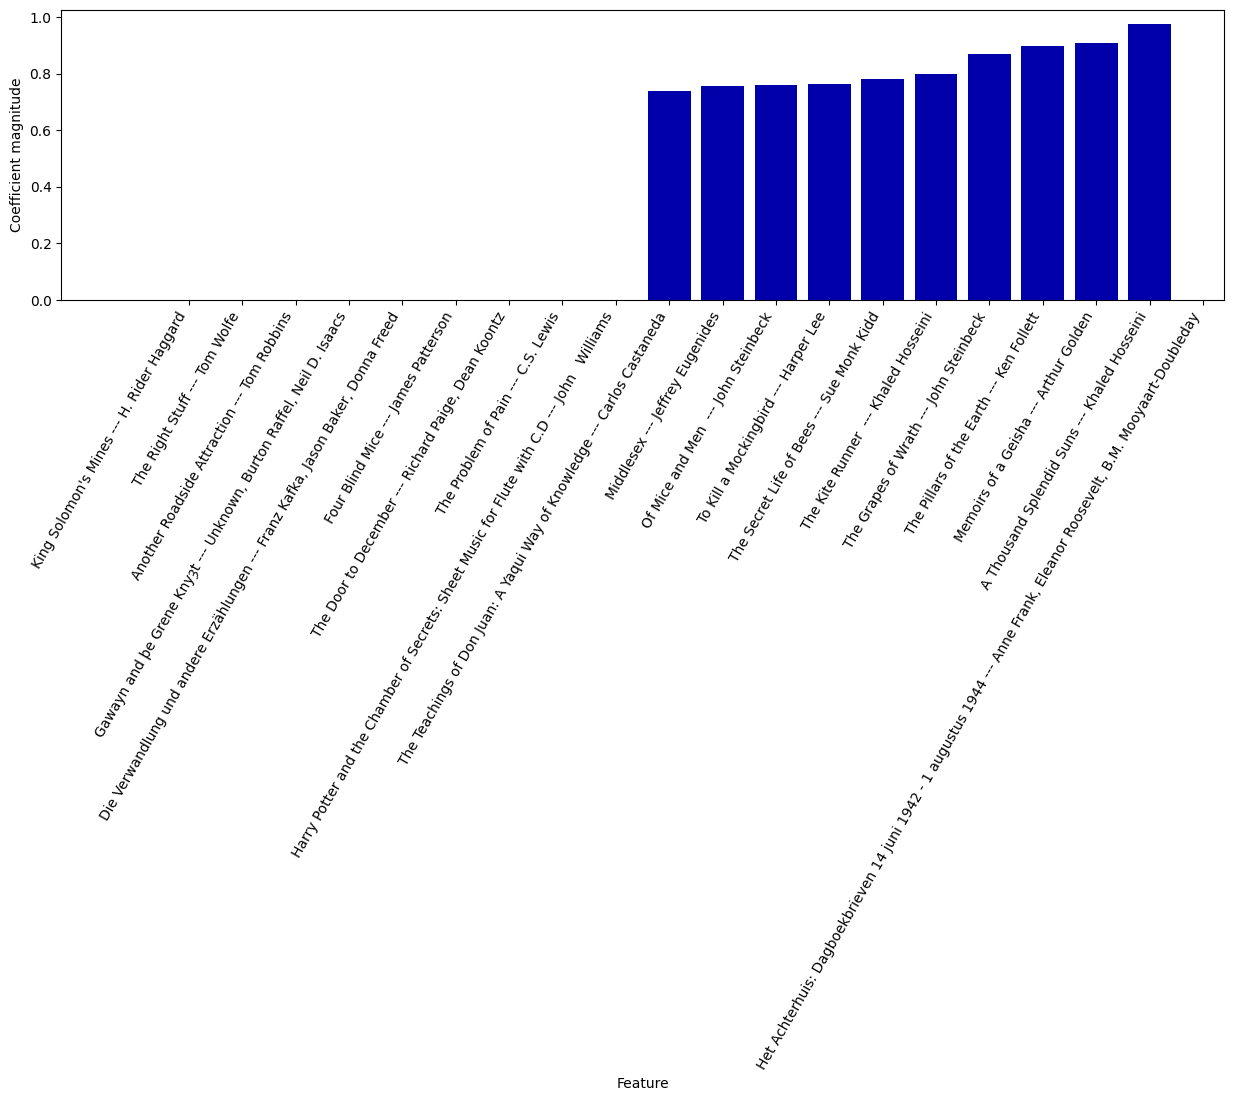

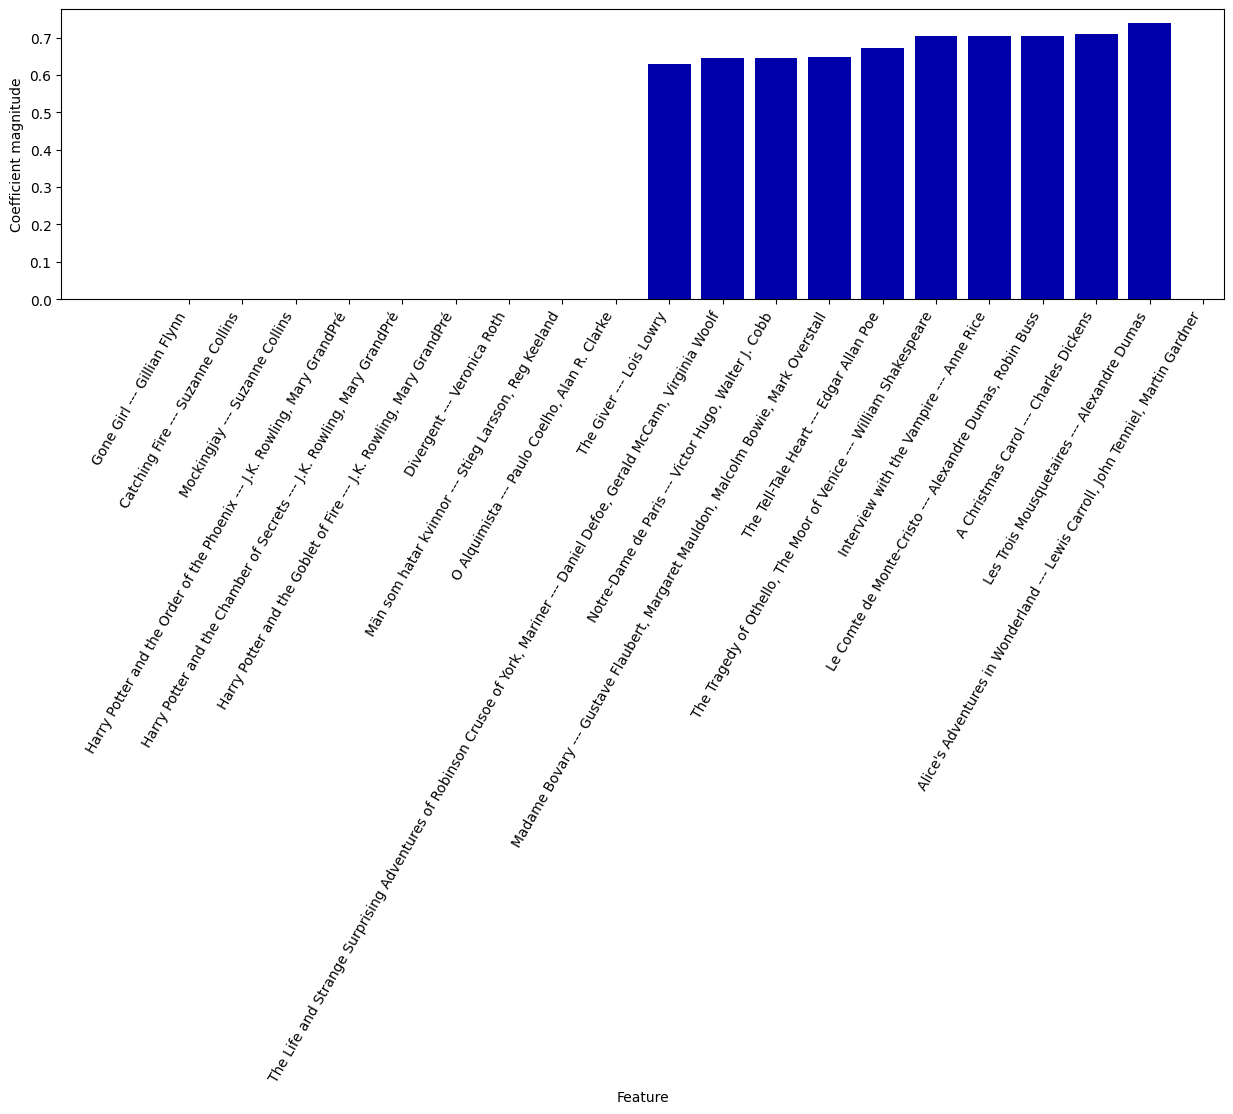

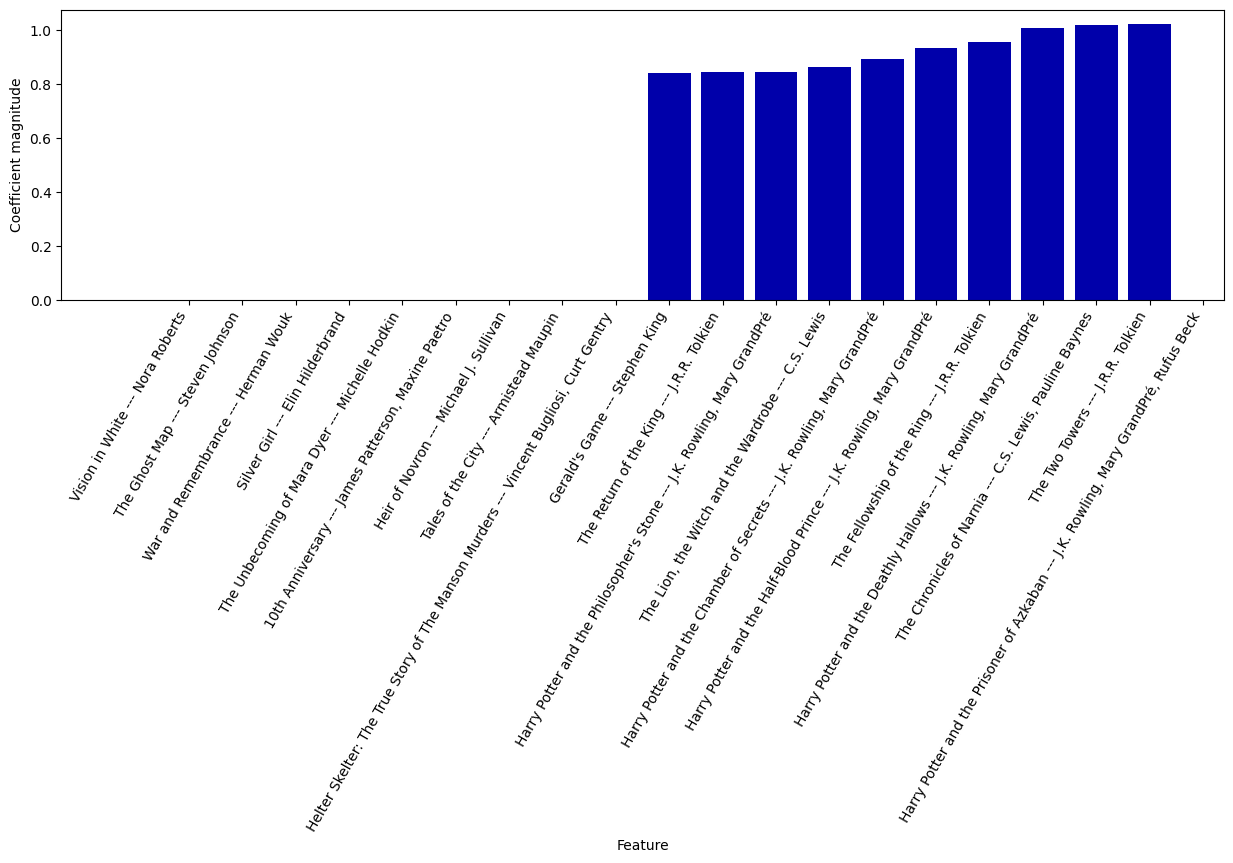

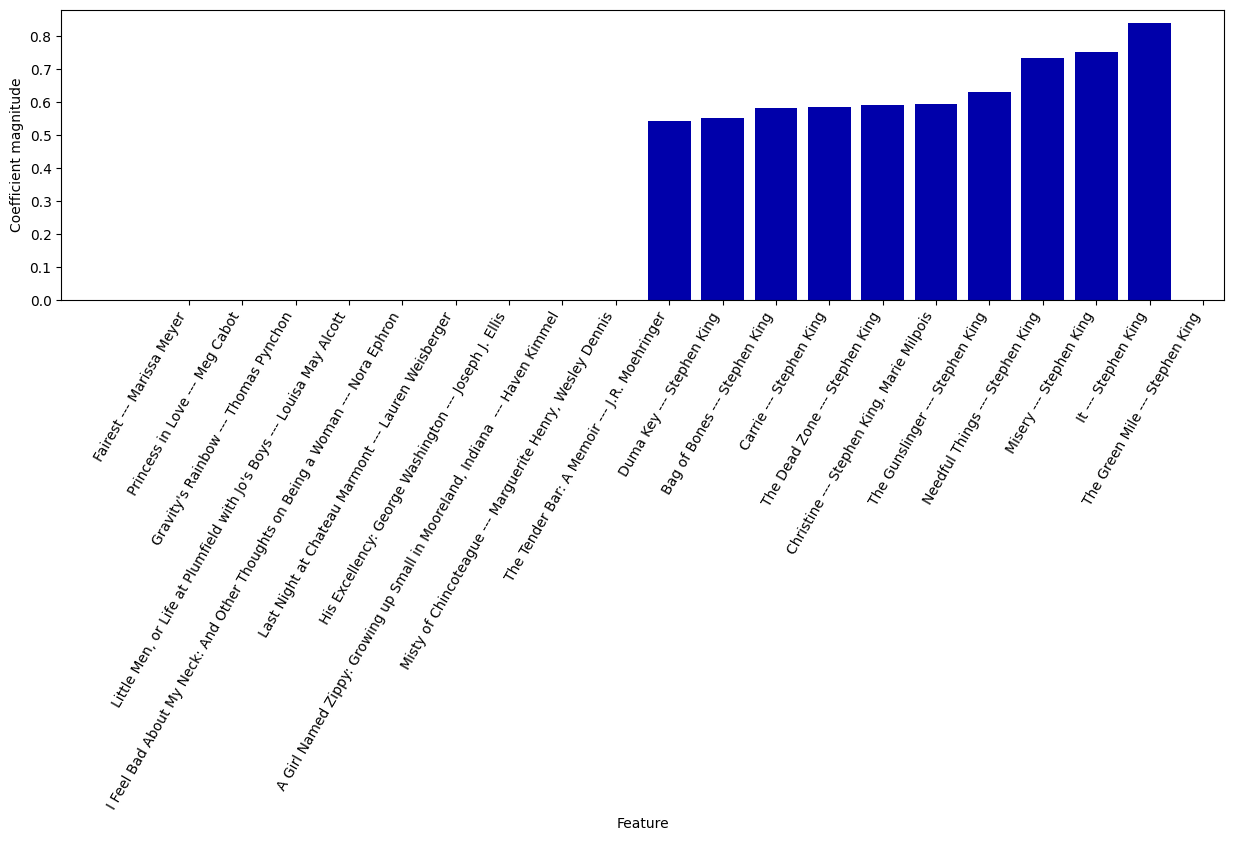

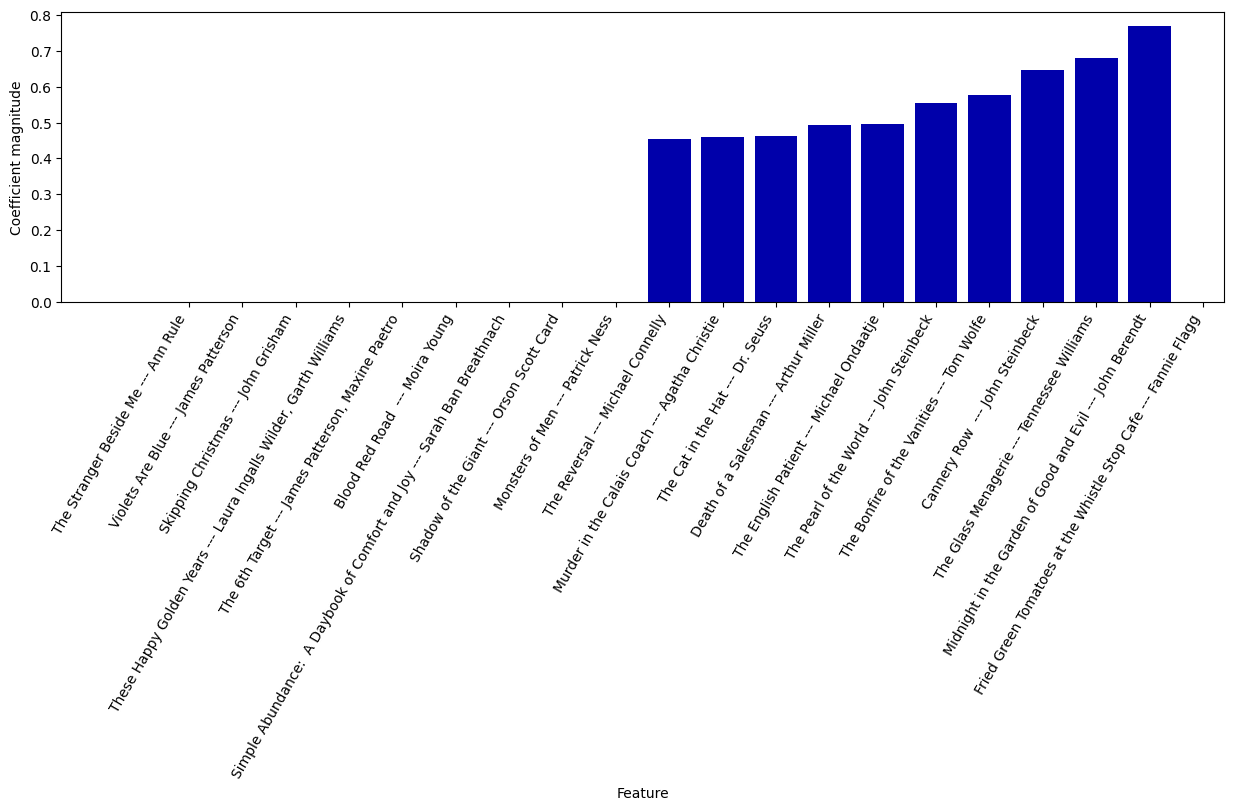

In [28]:
for i in range(n_components):
  print(f"Topic {i}:")
  mglearn.tools.visualize_coefficients(model.components_[i], feature_names, n_top_features=10)


It might take some effort to interpret the topics (or we may show them to a librarian... or ChatGPT?). But, here is a guess:

- **Topic 0:** Historic and social commentary.
- **Topic 1:** Classics
- **Topic 2:** Fantasy and Magic
- **Topic 3:** Stephen King Thrillers
- **Topic 4:** Southern and American Realism

In [29]:
topics = ["Historic & Social", "Classics", "Fantasy", "Thriller", "Southern Realistic"]

## Task 2: Topic Similarity and Collaborative Filtering

Now that we expressed the data in terms of an intermediate variable, the topics, we can do some interesting things...




### Book Representation in terms of Topics.

In [30]:
books_filtered

,authors,original_publication_year,original_title
book_id,,,
1,Suzanne Collins,2008.0,The Hunger Games
2,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone
3,Stephenie Meyer,2005.0,Twilight
4,Harper Lee,1960.0,To Kill a Mockingbird
5,F. Scott Fitzgerald,1925.0,The Great Gatsby
...,...,...,...
9761,Richard Llewellyn,1939.0,How Green Was My Valley
9796,"Else Holmelund Minarik, Maurice Sendak",1968.0,A Kiss for Little Bear
9892,J.D. Robb,2008.0,Salvation in Death


In [31]:
def get_book_id(book_name):
  return books[books["original_title"] == book_name].index[0]

def get_book_topics(name):
  book_id = get_book_id(name)
  book_features = pd.DataFrame(H[book_id])
  book_features.index = topics
  return book_features

In [32]:
book_name = "The Princess Diaries"
# "The Princess Diaries"
# "Life of Pi"
# "The Great Gatsby"
#"Harry Potter and the Order of the Phoenix"
#"Brave New World"
#"Animal Farm: A Fairy Story"

get_book_topics(book_name)

,500
Historic & Social,0.000000
Classics,0.000000
Fantasy,0.090672
Thriller,0.000000
Southern Realistic,0.041608


### User Representation in terms of Topics.

In [33]:
#Auxuliary function
def get_user_books(user_id):
  book_ids_read_by_user = ratings[ratings["user_id"] == user_id]["book_id"].to_list()
  books_read_by_user = books.index.isin(book_ids_read_by_user)
  return books.loc[books_read_by_user]

def get_user_topics(user_id):
  user_index = user_book_matrix.index.get_loc(user_id)
  user_topics = pd.DataFrame(W[user_index, :])
  user_topics.index = topics
  return user_topics

In [34]:
user_id = 53292# 2487 #951

display(get_user_books(user_id))
display(get_user_topics(user_id))

,authors,original_publication_year,original_title
book_id,,,
2,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone
3,Stephenie Meyer,2005.0,Twilight
4,Harper Lee,1960.0,To Kill a Mockingbird
5,F. Scott Fitzgerald,1925.0,The Great Gatsby
6,John Green,2012.0,The Fault in Our Stars
...,...,...,...
3132,Gail Carson Levine,2006.0,Fairest
3215,Sherrilyn Kenyon,2008.0,"Acheron (Dark-Hunter, #15) - Part 1"
3289,Ellen Schreiber,2003.0,Vampire Kisses


,0
Historic & Social,0.064355
Classics,0.120050
Fantasy,0.912245
Thriller,0.000000
Southern Realistic,0.000000


### What about new users and books?

Let's say you received a new set of users who read a mix of the books in your dataset and some new books.

You want to extract the topics of interest for these users based on their readings and based on the model you have created from your training data.

You will have to express the new users in terms of the books you have in your training dataset.

In [35]:
# Convert to Cross Tab format
user_book_matrix_new_users = new_user_df.pivot(index="user_id", columns="book_id", values="rating").fillna(0)

# Remove the books that were not in your training data
user_book_matrix_new_users = user_book_matrix_new_users[[column for column in user_book_matrix_new_users.columns if column in user_book_matrix.columns]]

# Fill in training books that were not read by these new users with zeros.
user_book_matrix_new_users = user_book_matrix_new_users.reindex(columns=user_book_matrix.columns, fill_value=0)

user_book_matrix_new_users

book_id,1,2,3,4,5,6,7,8,9,10,...,8817,8829,8870,9147,9360,9409,9623,9761,9923,9995
user_id,,,,,,,,,,,,,,,,,,,,,
951,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0,0,0,0.0,0.0,0.0,0,0.0
1185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0,0,0,4.0,0.0,0.0,0,0.0
1952,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0,0.0,0,0,0,0.0,0.0,0.0,0,0.0
2324,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0,0.0,0,0,0,0.0,0.0,0.0,0,0.0
2487,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0,0,0,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48687,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0,0,0,0.0,0.0,0.0,0,0.0
50999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0,0,0,0.0,0.0,0.0,0,0.0
52036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0,0,0,0.0,0.0,0.0,0,0.0


In [36]:
# Transform!
new_users_topics = pd.DataFrame(model.transform(user_book_matrix_new_users), columns=topics, index=user_book_matrix_new_users.index)
new_users_topics

,Historic & Social,Classics,Fantasy,Thriller,Southern Realistic
user_id,,,,,
951,0.155636,0.688571,0.274514,0.182319,0.404782
1185,0.028438,0.253915,0.191668,0.076519,0.091727
1952,0.424069,0.000000,0.147026,0.000000,0.118792
2324,0.439462,0.331996,0.195352,0.343470,0.000000
2487,0.061351,0.243023,0.103768,0.027037,0.195146
...,...,...,...,...,...
48687,0.609245,0.339437,0.020038,0.204323,0.063817
50999,0.139157,0.483167,0.042099,0.089000,0.058354
52036,0.269401,0.254709,0.108082,0.289300,0.099846


### Colaborative Filtering

Now, we can use the constructed model to *compare* books, users, or both!

In [37]:
#Auxuliary function
def get_book_readers(name):
  book_id = books[books["original_title"] == name].index[0]
  return scaled_user_book_matrix[book_id]

In [38]:
training_books = books[books.index.isin(train_df['book_id'])]
training_books

,authors,original_publication_year,original_title
book_id,,,
1,Suzanne Collins,2008.0,The Hunger Games
2,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone
3,Stephenie Meyer,2005.0,Twilight
4,Harper Lee,1960.0,To Kill a Mockingbird
5,F. Scott Fitzgerald,1925.0,The Great Gatsby
...,...,...,...
9409,Bette Greene,1973.0,Summer of My German Soldier
9623,Thomas Wolfe,1929.0,"Look Homeward, Angel"
9761,Richard Llewellyn,1939.0,How Green Was My Valley


#### How similar are two books?

In [39]:
book1 = "Ender's Game"
book2 = "Divergent"
#"The Adventures of Huckleberry Finn"
#"Le Comte de Monte-Cristo"
#"The Time Traveler's Wife"
#"The Book Thief"
#"Harry Potter and the Order of the Phoenix"
#"Nineteen Eighty-Four"
#"The Hitchhiker's Guide to the Galaxy"
#"A Tale of Two Cities"

# Get book_ids
book1_id = books[books["original_title"] == book1].index[0]
book2_id = books[books["original_title"] == book2].index[0]

# Get readers and topics
topics1 = get_book_topics(book1).values.reshape(1, -1)
readers1 = get_book_readers(book1).reshape(1, -1)

topics2 = get_book_topics(book2).values.reshape(1, -1)
readers2 = get_book_readers(book2).reshape(1, -1)



# Get cosine similarity in terms of readers and in terms of topics
from sklearn.metrics.pairwise import cosine_similarity
reader_similarity = cosine_similarity(readers1, readers2)[0, 0]
topics_similarity = cosine_similarity(topics1, topics2)[0, 0]

print("reader_similarity = ", reader_similarity)
print("topics_similarity = ", topics_similarity)

reader_similarity =  0.13913131657088135
topics_similarity =  0.9236351379300789


Notice how topic similarity is more meaningful.

#### Would a user be intersted in a certain book?

In [40]:
pd.DataFrame(W, index=user_book_matrix.index, columns = topics)

,Historic & Social,Classics,Fantasy,Thriller,Southern Realistic
user_id,,,,,
951,0.000000,0.639286,0.235606,0.000000,0.265695
1185,0.000000,0.167392,0.161697,0.000000,0.506795
1952,0.640045,0.131181,0.000000,0.000000,0.182886
2324,0.071023,0.282610,0.000000,1.087887,0.017362
2487,0.299490,0.221073,0.143415,0.000000,0.236957
...,...,...,...,...,...
48687,0.506460,0.190110,0.542230,0.051269,0.000000
50999,0.054204,0.063955,0.071894,0.037885,0.571322
52036,0.056628,0.562168,0.238490,0.273954,0.000000


In [41]:
user_id = 2487
user_topics_vector = pd.DataFrame(model.transform(user_book_matrix), index=user_book_matrix.index).loc[user_id] # pd.DataFrame(model.transform(user_book_matrix), index=user_book_matrix.index).loc[user_id] # or pd.DataFrame(W, index=user_book_matrix.index).loc[user_id]

book_name = "Harry Potter and the Order of the Phoenix"
book_topics_vector = get_book_topics(book_name)

In [42]:
cosine_similarity(book_topics_vector.values.reshape(1, -1), user_topics_vector.values.reshape(1, -1))[0, 0]

0.4512095356701717

## **Questions:**

- How would you think Topic Modeling could apply to association rules? Describe an example.
- What are the similarities and differences between Clustering and Topic Modeling? When would you use one or the other?
- What are the similarities and differences between PCA and Topic Modeling? When would you use one or the other?